In [98]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral, clockwise_angle
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get the current scan frame from the STM, get atom positions using Gaussian fits, and program lateral manipulation moves (in order of their labeling in the figure) using GUI. 
This may require fine-tuning the parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only the surface features you want to see are registered in the image frame when you run the cell.

succeed to connect
	30 centroids


<IPython.core.display.Javascript object>


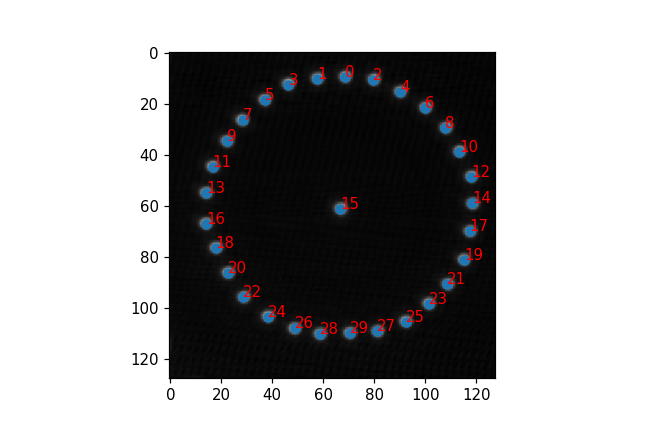

Textarea(value='[]', description='points:')

In [112]:
%matplotlib notebook

CC = Createc_Controller()

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
plt.scatter(*np.array(C.centroids).T)

# give numbers to atom positions
for n, c in enumerate(C.centroids):
    plt.text(*c,'%d' %(n), color='r')

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

# Function to run when a pixel is clicked
def onclick(event):
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    if (y, x) in selected:
        im[y,x] = C.im[y,x]
        dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
        selected.remove((y, x))
    else:
        dispmat[y,x,:] = [1,0,0]
        selected += [(y, x)]
    text_area.value = str(selected)  # str(dir(event))
    print(selected)
    plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

	Max height guess different from Gaussian fit on average by: 0.73 Å
	 2022-04-11 14:21:47.340525
	Central atom from Naive fit:  10.073487348718938 [66.64460506 60.2660558 ]
	Central atom from Gauss fit:  10.054810942614493 [66.43662829 60.09353968]


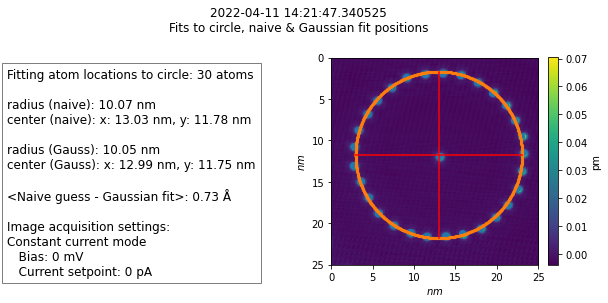

10.054810942614493

In [113]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1.1, savefig=False)

### Create the 'perfect circle' set of data points

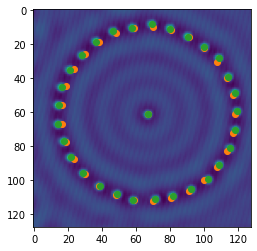

In [108]:
%matplotlib inline

n_wall_atoms = len(C.centroids) - 1
center = C.get_central_atom(C.centroids)

radius = 10
perfect_circle = np.array([[radius*np.cos(t), radius*np.sin(t)] for t in np.arange(0, 2*np.pi, 2*np.pi/(n_wall_atoms))])
perfect_circle = np.concatenate((perfect_circle, [[0,0]]))
perfect_circle = list(map(C.nm_to_pix, perfect_circle))
perfect_circle += np.array(center)

assert(len(perfect_circle)==len(C.centroids))

plt.imshow(C.im);
plt.scatter(*center)
plt.scatter(*(np.array(perfect_circle).T))
plt.scatter(*np.array(C.centroids).T)
plt.show()

zero vector


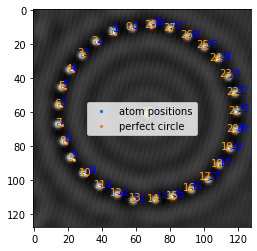

In [110]:
# Kabsch algorithm for the best rotation between two sets to minimize distance
from scipy.spatial.transform import Rotation

# create 3D arrays to align vectors using algorithm
# subtract the center
centroids_3D = np.array(C.centroids) - np.array(center)

# need to order centroids in same order as perfect circle to make Kabsch algo work
refvec = [0, 1]
clockwise_angle = lambda point: clockwiseangle(point, [0,0], refvec)
centroids_3D = np.array(sorted(centroids_3D, key=clockwise_angle))

perfect_circle_3D = np.array(perfect_circle) - np.array(center)

centroids_3D = np.append(centroids_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T
perfect_circle_3D = np.append(perfect_circle_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T

R, rmsd_ = Rotation.align_vectors(centroids_3D, perfect_circle_3D)

applied_rotation = R.apply(perfect_circle_3D)[:,0:2].T
applied_rotation = [x + center for x in applied_rotation.T]

centroids_3D = np.array([c + center for c in centroids_3D[:,0:2]])


plt.imshow(dispmat);

plt.scatter(*np.array(centroids_3D).T, label="atom positions", s=5)
plt.scatter(*np.array(applied_rotation).T, label="perfect circle", s=5)
plt.legend()

for n,c in enumerate(centroids_3D):
    #print(*centroids_3D[:][n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[:,][n], dispmat, offset_nm, [len_nm, len_nm])
    
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    
    dx, dy = (np.array(applied_rotation[n]) - np.array(centroids_3D[n]))
    
    plt.text(*c,'%d' %(n), color='blue')
    plt.text(*(applied_rotation[n]-[4,0]),'%d' %(n), color='orange')

    plt.arrow(*centroids_3D[n], dx, dy, color="white")
plt.show()

#np.dot(R.as_matrix(), perfect_circle_3D)

[57.5 10.5] [57.91458795 10.85823448]


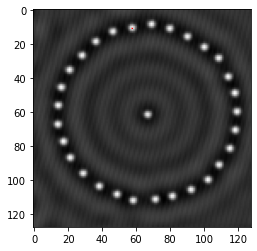

[46.5 12.5] [47.30500834 13.98829201]


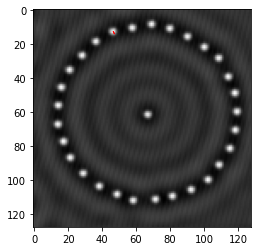

46 12 47 14
[36.5 18.5] [37.61634465 19.32591653]


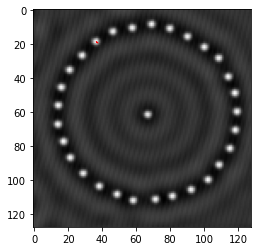

36 18 38 19
[28.38461538 26.61538462] [29.30162803 26.62152666]


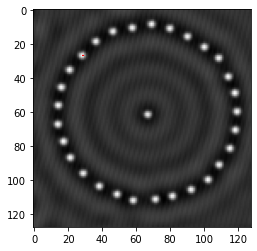

[21.  35.2] [22.74964538 35.53398777]


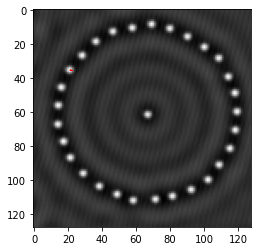

21 35 23 36
[16.38461538 45.38461538] [18.26676013 45.64656309]


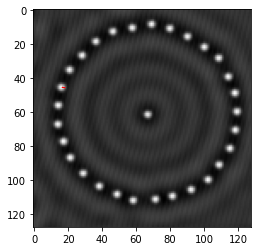

16 45 18 46
[14.5 56. ] [16.06258702 56.48639983]


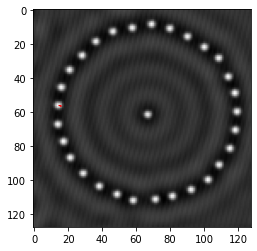

14 56 16 56
[14.18181818 67.18181818] [16.24019072 67.54663927]


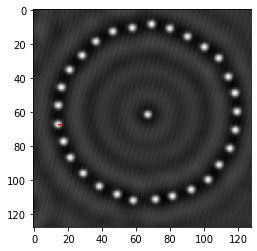

14 67 16 68
[17.5        77.28571429] [18.79126669 78.31011692]


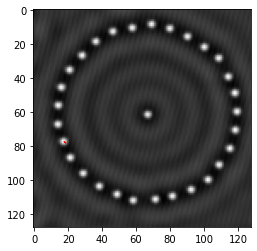

18 77 19 78
[21.5 86.5] [23.59652945 88.27354451]


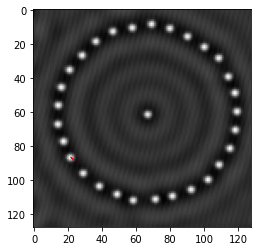

22 86 24 88
[29. 96.] [30.43129026 96.97104326]


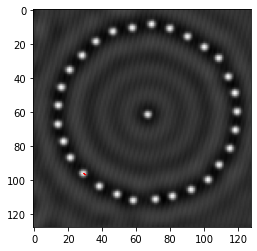

29 96 30 97
[ 38.5 103.5] [ 38.97596329 103.99592777]


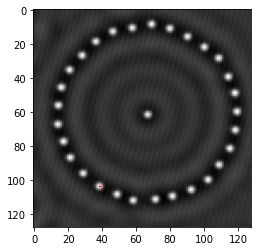

[ 48.81818182 108.18181818] [ 48.83100912 109.01972227]


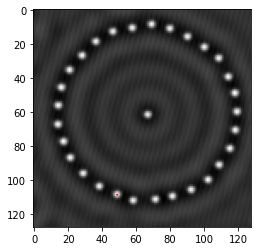

[ 58.36363636 111.90909091] [ 59.53561678 111.80751971]


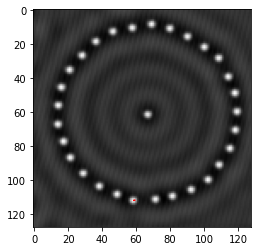

58 112 60 112
[ 71.36363636 111.09090909] [ 70.5892507  112.22896577]


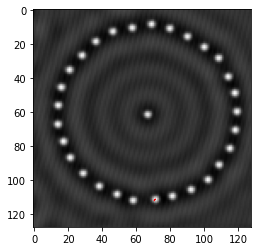

71 111 71 112
[ 81.5 109.5] [ 81.47505525 110.2643541 ]


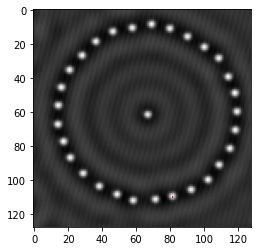

[ 92.5 105.5] [ 91.6840223  106.00554777]


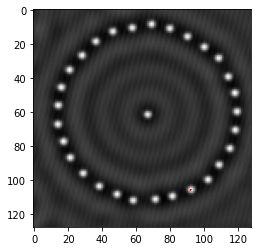

[102.5  99.5] [100.73879191  99.65168382]


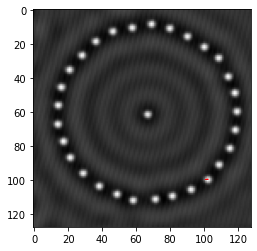

102 100 101 100
[108.8  91. ] [108.2159731   91.49986187]


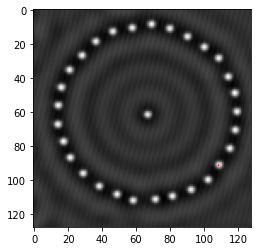

[115.09090909  81.36363636] [113.7659412   81.93125206]


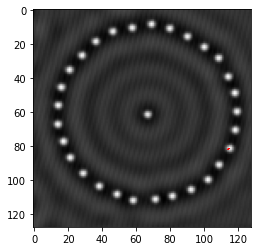

115 81 114 82
[118.5  70.5] [117.12918586  71.39327194]


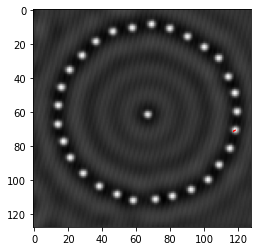

118 70 117 71
[119.38461538  59.61538462] [118.14844551  60.37866576]


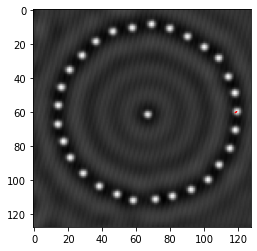

119 60 118 60
[118.33333333  48.75      ] [116.77606069  49.40246425]


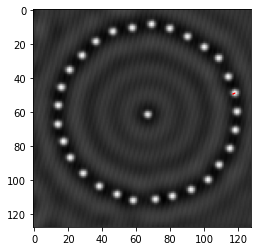

118 49 117 49
[114.18181818  39.18181818] [113.0762026  38.9779024]


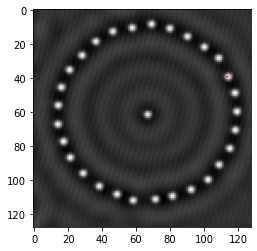

114 39 113 39
[108.61538462  28.38461538] [107.22187248  29.59242113]


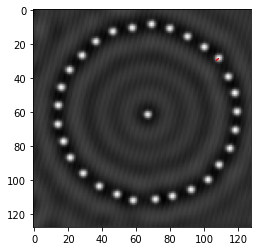

109 28 107 30
[100.18181818  21.81818182] [99.48681231 21.68487513]


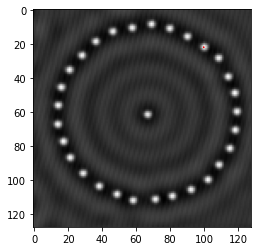

[90.38461538 15.61538462] [90.23270491 15.62501245]


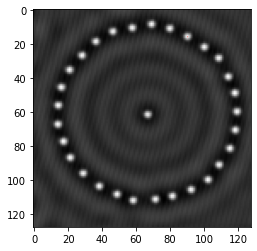

[79.8 11. ] [79.89226204 11.69618553]


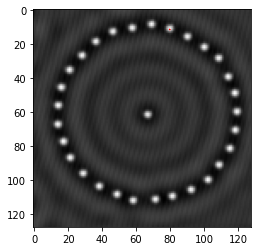

[69.09090909  8.36363636] [68.94899133 10.08210195]


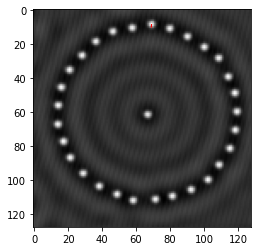

69 8 69 10
[67.  61.2] [67.  61.2]


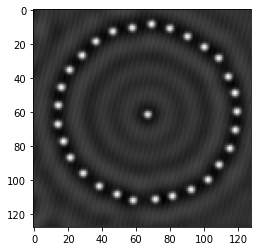

In [111]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids_3D)):
    print(centroids_3D[n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids_3D[n], *(np.array(applied_rotation[n])-np.array(centroids_3D[n])), color='red')
    plt.show()
    
    dist_to_perfect = C.pix_to_nm(np.linalg.norm(np.array(applied_rotation[n])-np.array(centroids_3D[n])))
    if dist_to_perfect > 0.2: # nm 
    # see documentation in AMRL/Environment/createc_control.py
        latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run GUI notebook cell again and program lateral manipulations again using GUI.

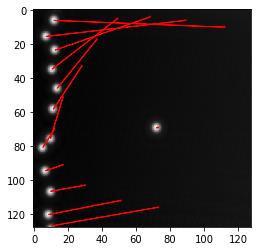

In [50]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
centroids = C.centroids

for n, c in enumerate(C.centroids):
    plt.arrow(*c, *(np.array(list(reversed(selected[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()
#

## Carry out lateral manipulations in order 

[11.5, 6.0] [112, 10]


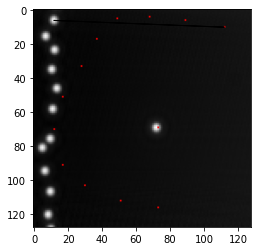

12 6 112 10
[6.846153846153846, 15.461538461538462] [89, 6]


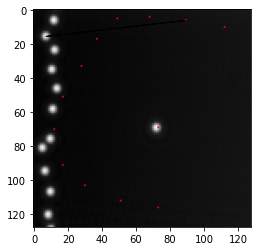

7 15 89 6
[12.285714285714286, 23.5] [68, 4]


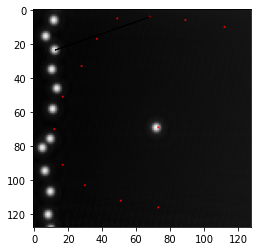

12 24 68 4
[10.5, 34.714285714285715] [49, 5]


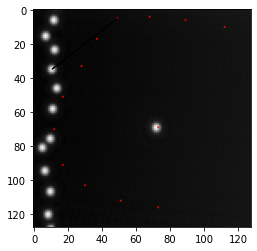

10 35 49 5
[13.5, 46.0] [37, 17]


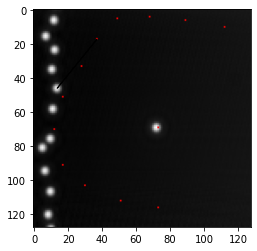

14 46 37 17
[11.25, 58.333333333333336] [28, 33]


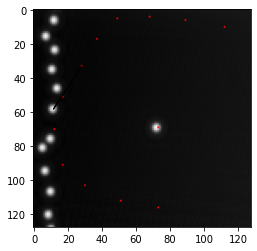

11 58 28 33
[71.875, 69.3125] [73, 69]


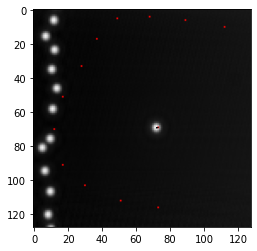

72 69 73 69
[9.615384615384615, 75.61538461538461] [17, 51]


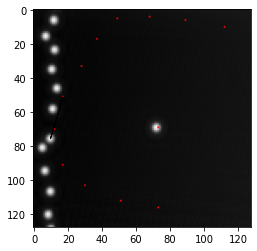

10 76 17 51
[5.071428571428571, 80.85714285714286] [12, 70]


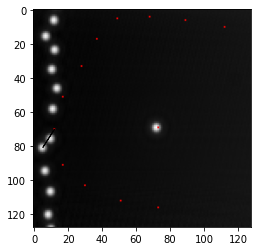

5 81 12 70
[6.5, 94.5] [17, 91]


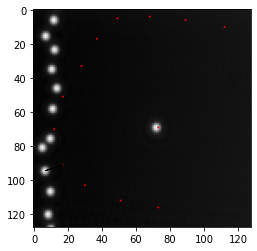

6 94 17 91
[9.615384615384615, 106.61538461538461] [30, 103]


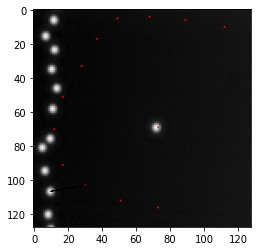

10 107 30 103
[8.5, 120.28571428571429] [51, 112]


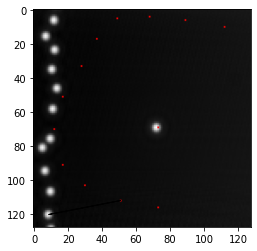

8 120 51 112
[10.0, 127.0] [73, 116]


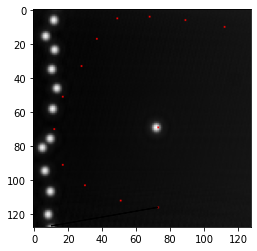

10 127 73 116


In [51]:
# set the lateral manipulation parameters
latman_millivolt = 2
latman_picoamp = 60000
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids)):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])))
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)

In [250]:
# the units of this is unknown ? 
plt.plot(latmandata.y)

NameError: name 'latmandata' is not defined